In [5]:
from dotenv import load_dotenv
import os
import json
import pandas as pd
from openai import OpenAI
from pydantic import BaseModel, Field
from src.dataimport import list_files_with_extension_directory, load_text
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate

# load files

In [6]:
TXT_FILES_PATH = 'data/original/brat-project-final/'
JSON_FILES_PATH = 'data/transformed/'

In [7]:
txt_files_directory_list = list_files_with_extension_directory(TXT_FILES_PATH, '.txt')
# txt_files_directory_list

json_files_directory_list = list_files_with_extension_directory(JSON_FILES_PATH, '.json')
# json_files_directory_list

print(f"Anzahl Text-Dateien: {len(txt_files_directory_list)}")
print(f"Anzahl Brat-Dateien: {len(json_files_directory_list)}")

Anzahl Text-Dateien: 402
Anzahl Brat-Dateien: 402


In [8]:
# create dataframe with file names
df = pd.DataFrame()
df['txt_path'] = txt_files_directory_list
df['json_path'] = json_files_directory_list
df['txt_file'] = df['txt_path'].apply(lambda x: os.path.basename(x))
df['json_file'] = df['json_path'].apply(lambda x: os.path.basename(x))
df['txt'] = df['txt_path'].apply(load_text)
df['json'] = df['json_path'].apply(load_text)

print(df.shape)
df.head()

# save to csv
#df.to_csv('dataframe.csv', index=False)
# load dataframe
# df = pd.read_csv('dataframe.csv')
# df.head()

(402, 6)


,txt_path,json_path,txt_file,json_file,txt,json
0,data/original/brat-project-final/essay001.txt,data/transformed/essay001.json,essay001.txt,essay001.json,Should students be taught to compete or to coo...,"{\n ""MajorClaims"": {\n ""MC1"": ""we should a..."
1,data/original/brat-project-final/essay002.txt,data/transformed/essay002.json,essay002.txt,essay002.json,More people are migrating to other countries t...,"{\n ""MajorClaims"": {\n ""MC1"": ""they are ab..."
2,data/original/brat-project-final/essay003.txt,data/transformed/essay003.json,essay003.txt,essay003.json,International tourism is now more common than ...,"{\n ""MajorClaims"": {\n ""MC1"": ""it has cont..."
3,data/original/brat-project-final/essay004.txt,data/transformed/essay004.json,essay004.txt,essay004.json,International tourism is now more common than ...,"{\n ""MajorClaims"": {\n ""MC1"": ""this indust..."
4,data/original/brat-project-final/essay005.txt,data/transformed/essay005.json,essay005.txt,essay005.json,Living and studying overseas\n\nIt is every st...,"{\n ""MajorClaims"": {\n ""MC1"": ""one who stu..."


# train test split

In [9]:
# Split the dataframe into training and test sets
train_df, test_df = train_test_split(df, train_size=40, random_state=42)

# Display the first few rows of the training and test sets
print(f"Training DataFrame: {train_df.shape}")
print(f"\nTest DataFrame: {test_df.shape}")

Training DataFrame: (40, 6)

Test DataFrame: (362, 6)


# load prompt templates

In [19]:
PROMPTS_PATH = 'prompts/final-prompts/'

In [20]:
prompt_files_directory_list = list_files_with_extension_directory(PROMPTS_PATH, '.txt')
prompt_files_directory_list
prompt_files_list = [os.path.basename(x) for x in prompt_files_directory_list]
# remove the .txt extension
prompt_names = [x.split('.')[0] for x in prompt_files_list]

prompt_df = pd.DataFrame()
# get the file name without the extension from prompt_files, 'str' object has no attribute 'path'
prompt_df['prompt_name'] = prompt_names
prompt_df['prompt_txt'] = prompt_files_directory_list
prompt_df['prompt_txt'] = prompt_df['prompt_txt'].apply(load_text)
print(F"Es gibt {prompt_df.shape[0]} Prompts")
# prompt_df

Es gibt 20 Prompts


In [21]:
# get the API key from the .env file
load_dotenv()
llama_api = os.getenv("HUGGINGFACE_TOKEN")

model_id = "meta-llama/Llama-3.2-3B-Instruct"
# model_id = "meta-llama/Llama-3.3-70B-Instruct" # requires HugginFace Pro subscription

# Function to calculate token count
def calculate_token_count(prompt):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenized_prompt = tokenizer(prompt, return_tensors='pt') # pt for PyTorch tensors
    return tokenized_prompt.input_ids.size(1)

# Apply the function to the 'prompt' column and create a new column 'token_count'
prompt_df['token_count'] = prompt_df['prompt_txt'].apply(calculate_token_count)

prompt_df.sort_values(by='token_count')

,prompt_name,prompt_txt,token_count
19,zero-shot,You will be given a text. Extract the argument...,102
18,zero-shot-persona,You are a expert in Argument Mining and theref...,126
16,zero-shot-cot,You will be given a text. Extract the argument...,470
17,zero-shot-persona-cot,You are a expert in Argument Mining and theref...,494
15,one-shot,You will be given a text. Extract the argument...,1550
14,one-shot-persona,You are a expert in Argument Mining and theref...,1562
12,one-shot-cot,You will be given a text. Extract the argument...,1907
13,one-shot-persona-cot,You are a expert in Argument Mining and theref...,1931
3,few-shot-10,You will be given a text. Extract the argument...,12088
2,few-shot-10-persona,You are a expert in Argument Mining and theref...,12112


In [22]:
# structured output 
class ArgumentativeRelation(BaseModel):
    """Argumentative relation between the origin and target"""
    origin_id: str = Field(description="ID of the claim or premise")
    relation_type: str = Field(description="Type of relation (e.g., 'For', 'Against', 'Support', 'Attack')")
    target_id: str = Field(description="ID of the target (e.g., Major Claim ID)")

class ArgumentMiningExtraction(BaseModel):
    """Extraction of argument components and relations from a text"""
    major_claims: dict[str, str] = Field(description="Dictionary of major claims with their IDs as keys and text as values")
    claims: dict[str, str] = Field(description="Dictionary of claims with their IDs as keys and text as values")
    premises: dict[str, str] = Field(description="Dictionary of premises with their IDs as keys and text as values")
    argumentative_relations: list[ArgumentativeRelation] = Field(description="List of argumentative relations between origin and target")

    
# Quellen Structured Outputs:
# - https://platform.openai.com/docs/guides/structured-outputs
# - https://python.langchain.com/docs/concepts/structured_outputs/
# - https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html -->Structured output

# allgemeiner Test

In [24]:
load_dotenv()
openai_api = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_api)

llm = ChatOpenAI(
    model="gpt-4o-mini",
    #max_tokens=1024,
    #max_tokens_input=1024,
    temperature=0,
    timeout=None,
    # max_retries=2,
    api_key=openai_api,
    #response_format=ArgumentMiningExtraction
    )

In [25]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="J'aime la programmation.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 31, 'total_tokens': 37, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-10370652-6415-4656-9498-3521cebcd09c-0', usage_metadata={'input_tokens': 31, 'output_tokens': 6, 'total_tokens': 37, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [26]:
print(ai_msg.content)

J'aime la programmation.


In [27]:
# Token usage tracking
ai_msg.usage_metadata

# Quelle: 
# - https://python.langchain.com/docs/how_to/chat_token_usage_tracking/
# - https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html

{'input_tokens': 31,
 'output_tokens': 6,
 'total_tokens': 37,
 'input_token_details': {'audio': 0, 'cache_read': 0},
 'output_token_details': {'audio': 0, 'reasoning': 0}}

# Argument mining Test

In [43]:
# Beispiel aus Testdatensatz
test_data_example = test_df.sample(1, random_state=42)
test_data_example_txt = test_data_example['txt'].values[0]
print(test_data_example_txt) 

The precondition of doing research by professors

Nowadays, many professors conduct research while teaching in colleges or universities. Although research could bring funding and latest achievements in the field, the research takes up too much teaching time. As far as I am concerned, professors should spend more time on preparing courses than research.
To begin with, it is vital that professors should assist students to acquire knowledge. The professors’ duty is to nurture students, and prepare excellent courses. If professors spend a lot of time on research, he will cut the time on preparing courses is reduced, which may decrease the quality of classes. The reason why people enter a university is that they want to learn cutting-edged technologies. In this way, professors should provide well-preparation courses to convey the state-of-art knowledge for college and university students. Therefore, professors should pay more attention on how to teach students rather than conduct research.


In [32]:
# zero-shot als test-prompt
zero_shot_prompt = prompt_df.loc[prompt_df['prompt_name'] == 'zero-shot', 'prompt_txt'].values[0]
zero_shot_prompt

'You will be given a text. Extract the argumentative units “major claim”, “claim”, and “premise” as parts from the text. Also extract the argumentative relationships between the units. Claims can be “for” or “against” the major claims. Premises, on the other hand, can “support” or “attack” a claim or another premise. It is possible that there are several major claims. Return only the argumentative units and relationships between them as a JSON object.'

In [40]:
load_dotenv()
openai_api = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_api)

In [48]:
llm_struc_output = ChatOpenAI(
    model="gpt-4o-mini",
    #max_tokens=1024,
    #max_tokens_input=1024,
    temperature=0,
    timeout=None,
    # max_retries=2,
    api_key=openai_api,
    #response_format=ArgumentMiningExtraction,
    model_kwargs={"structured_output": True,
                  "structured_output_type": ArgumentMiningExtraction}
    )

# llm_struc_output

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x000002104F1916A0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x000002104F1934A0>, root_client=<openai.OpenAI object at 0x000002104F15B050>, root_async_client=<openai.AsyncOpenAI object at 0x000002104F1915E0>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={'structured_output': True, 'structured_output_type': <class '__main__.ArgumentMiningExtraction'>}, openai_api_key=SecretStr('**********'))

In [42]:
# template
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "{system_message}"),
        ("user", "Text: {argument_text}"),
    ]
)

# print example for one prompt template
print(
    prompt_template.invoke(
        {
            "system_message": zero_shot_prompt,
            "argument_text": test_data_example_txt,
        }
    )
)

messages=[SystemMessage(content='You will be given a text. Extract the argumentative units “major claim”, “claim”, and “premise” as parts from the text. Also extract the argumentative relationships between the units. Claims can be “for” or “against” the major claims. Premises, on the other hand, can “support” or “attack” a claim or another premise. It is possible that there are several major claims. Return only the argumentative units and relationships between them as a JSON object.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Text: The precondition of doing research by professors\n\nNowadays, many professors conduct research while teaching in colleges or universities. Although research could bring funding and latest achievements in the field, the research takes up too much teaching time. As far as I am concerned, professors should spend more time on preparing courses than research.\nTo begin with, it is vital that professors should assist students to acquire kn

In [39]:
llm_chain = prompt_template | llm
llm_chain

ChatPromptTemplate(input_variables=['argument_text', 'system_message'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['system_message'], input_types={}, partial_variables={}, template='{system_message}'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['argument_text'], input_types={}, partial_variables={}, template='Text: {argument_text}'), additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x000002104EFF90A0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x000002104EFFADB0>, root_client=<openai.OpenAI object at 0x000002104C85C980>, root_async_client=<openai.AsyncOpenAI object at 0x000002104EFF9100>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'))

## zero-shot

In [43]:
zero_shot_answ = llm_chain.invoke(
    {
        "system_message": zero_shot_prompt,
        "argument_text": test_data_example_txt,
    }
)
zero_shot_answ

AIMessage(content='```json\n{\n  "units": {\n    "major_claims": [\n      "Professors should spend more time on preparing courses than research.",\n      "Conducting research is helpful for professors and students to some extent."\n    ],\n    "claims": [\n      {\n        "claim": "Professors should assist students to acquire knowledge.",\n        "relationship": "support",\n        "to": "Professors should spend more time on preparing courses than research."\n      },\n      {\n        "claim": "If professors spend a lot of time on research, the quality of classes may decrease.",\n        "relationship": "support",\n        "to": "Professors should spend more time on preparing courses than research."\n      },\n      {\n        "claim": "If professors are busy in doing research, it would ruin the reputation of universities.",\n        "relationship": "support",\n        "to": "Professors should spend more time on preparing courses than research."\n      },\n      {\n        "claim": 

In [45]:
print(zero_shot_answ.content)

```json
{
  "units": {
    "major_claims": [
      "Professors should spend more time on preparing courses than research.",
      "Conducting research is helpful for professors and students to some extent."
    ],
    "claims": [
      {
        "claim": "Professors should assist students to acquire knowledge.",
        "relationship": "support",
        "to": "Professors should spend more time on preparing courses than research."
      },
      {
        "claim": "If professors spend a lot of time on research, the quality of classes may decrease.",
        "relationship": "support",
        "to": "Professors should spend more time on preparing courses than research."
      },
      {
        "claim": "If professors are busy in doing research, it would ruin the reputation of universities.",
        "relationship": "support",
        "to": "Professors should spend more time on preparing courses than research."
      },
      {
        "claim": "Spending more time to nurture excellent st

In [46]:
zero_shot_answ.usage_metadata

{'input_tokens': 573,
 'output_tokens': 630,
 'total_tokens': 1203,
 'input_token_details': {'audio': 0, 'cache_read': 0},
 'output_token_details': {'audio': 0, 'reasoning': 0}}

## one shot

In [51]:
# zero-shot als test-prompt
one_shot_prompt = prompt_df.loc[prompt_df['prompt_name'] == 'one-shot', 'prompt_txt'].values[0]
print(one_shot_prompt)

You will be given a text. Extract the argumentative units “major claim”, “claim”, and “premise” as parts from the text. Also extract the argumentative relationships between the units. Claims can be “for” or “against” the major claims. Premises, on the other hand, can “support” or “attack” a claim or another premise. It is possible that there are several major claims. Return only the argumentative units and relationships between them as a JSON object.Here is one example of a text and its corresponding json data:
## Input:
Do you think it is good for teenagers to work while schooling?

In my opinion, it is not the good idea for teenagers to have job while they are still students. Although, many argue that it provide good working experience, but I think it can interfere with their life in various ways. Having jobs would affect the health of the student. It divert their mind from studies and would take away their childhood phase from their life.
A student has to do lots of studies in today

In [70]:
# one-shot
os_template = prompt_template.invoke(
        {
            "system_message": one_shot_prompt,
            "argument_text": test_data_example_txt,
        }
    )
print(os_template)

messages=[SystemMessage(content='You will be given a text. Extract the argumentative units “major claim”, “claim”, and “premise” as parts from the text. Also extract the argumentative relationships between the units. Claims can be “for” or “against” the major claims. Premises, on the other hand, can “support” or “attack” a claim or another premise. It is possible that there are several major claims. Return only the argumentative units and relationships between them as a JSON object.Here is one example of a text and its corresponding json data:\n## Input:\nDo you think it is good for teenagers to work while schooling?\n\nIn my opinion, it is not the good idea for teenagers to have job while they are still students. Although, many argue that it provide good working experience, but I think it can interfere with their life in various ways. Having jobs would affect the health of the student. It divert their mind from studies and would take away their childhood phase from their life.\nA stud

In [71]:
system_msg = os_template.messages[0].content 
# print(system_msg)
user_msg = os_template.messages[1].content
# print(user_msg)

In [72]:
os_answ = llm_chain.invoke(
    {
        "system_message": one_shot_prompt,
        "argument_text": test_data_example_txt,
    }
)

'{\n  "MajorClaims": {\n    "MC1": "professors should spend more time on preparing courses than research",\n    "MC2": "spending more time to nurture excellent students is more consequential to professors, rather than research",\n    "MC3": "the precondition of doing research is growing students’ solid theory fundamental"\n  },\n  "Claims": {\n    "C1": "research could bring funding and latest achievements in the field",\n    "C2": "the research takes up too much teaching time",\n    "C3": "professors should assist students to acquire knowledge",\n    "C4": "the professors’ duty is to nurture students, and prepare excellent courses",\n    "C5": "if professors spend a lot of time on research, the time on preparing courses is reduced",\n    "C6": "this may decrease the quality of classes",\n    "C7": "students want to learn cutting-edged technologies",\n    "C8": "professors should provide well-preparation courses to convey the state-of-art knowledge",\n    "C9": "if professors are busy 

In [74]:
print(os_answ.content)

{
  "MajorClaims": {
    "MC1": "professors should spend more time on preparing courses than research",
    "MC2": "spending more time to nurture excellent students is more consequential to professors, rather than research",
    "MC3": "the precondition of doing research is growing students’ solid theory fundamental"
  },
  "Claims": {
    "C1": "research could bring funding and latest achievements in the field",
    "C2": "the research takes up too much teaching time",
    "C3": "professors should assist students to acquire knowledge",
    "C4": "the professors’ duty is to nurture students, and prepare excellent courses",
    "C5": "if professors spend a lot of time on research, the time on preparing courses is reduced",
    "C6": "this may decrease the quality of classes",
    "C7": "students want to learn cutting-edged technologies",
    "C8": "professors should provide well-preparation courses to convey the state-of-art knowledge",
    "C9": "if professors are busy in doing researc

In [73]:
os_answ.usage_metadata

{'input_tokens': 2018,
 'output_tokens': 1138,
 'total_tokens': 3156,
 'input_token_details': {'audio': 0, 'cache_read': 0},
 'output_token_details': {'audio': 0, 'reasoning': 0}}

# Evaluation
Start here so you dont need to invoke the llm every time. Just use the output for further processing. 

In [28]:
output_str = """{
  "MajorClaims": {
    "MC1": "professors should spend more time on preparing courses than research",
    "MC2": "spending more time to nurture excellent students is more consequential to professors, rather than research",
    "MC3": "the precondition of doing research is growing students’ solid theory fundamental"
  },
  "Claims": {
    "C1": "research could bring funding and latest achievements in the field",
    "C2": "the research takes up too much teaching time",
    "C3": "professors should assist students to acquire knowledge",
    "C4": "the professors’ duty is to nurture students, and prepare excellent courses",
    "C5": "if professors spend a lot of time on research, the time on preparing courses is reduced",
    "C6": "this may decrease the quality of classes",
    "C7": "students want to learn cutting-edged technologies",
    "C8": "professors should provide well-preparation courses to convey the state-of-art knowledge",
    "C9": "if professors are busy in doing research, it would ruin the reputation of universities",
    "C10": "students are unsatisfied with the unprepared course",
    "C11": "the enrollment of universities may decline",
    "C12": "hardly can professors find assistants to help with projects",
    "C13": "spending more time to nurture excellent students is more consequential to professors, rather than research",
    "C14": "professors could teach students through research and projects",
    "C15": "some students enjoy taking part in some research",
    "C16": "they may get more experience in the process of research",
    "C17": "only under specific circumstance, when students master all of the systematic knowledge, can they accomplish research",
    "C18": "this requires professors provide high quality courses",
    "C19": "conducting research is helpful for professors and students to some extent",
    "C20": "professors could combine doing research and preparing good courses in a dynamic way"
  },
  "Premises": {
    "P1": "the reason why people enter a university is that they want to learn cutting-edged technologies",
    "P2": "students would not choose these kinds of universities to study",
    "P3": "it is adverse to the whole academic field",
    "P4": "through to use the equipment and invent their own work, students may get more experience",
    "P5": "electronic students always invent new machines such as robots, MP3 and remote control car",
    "P6": "they can manage the electric theory in practical skills",
    "P7": "some students will be rewarded by investing new inventions"
  },
  "ArgumentativeRelations": [
    {
      "Claim": "C1",
      "Relation": "For",
      "Target": "MC1"
    },
    {
      "Claim": "C2",
      "Relation": "For",
      "Target": "MC1"
    },
    {
      "Claim": "C3",
      "Relation": "For",
      "Target": "MC1"
    },
    {
      "Claim": "C4",
      "Relation": "For",
      "Target": "MC1"
    },
    {
      "Claim": "C5",
      "Relation": "supports",
      "Target": "C4"
    },
    {
      "Claim": "C6",
      "Relation": "supports",
      "Target": "C5"
    },
    {
      "Claim": "C7",
      "Relation": "supports",
      "Target": "C4"
    },
    {
      "Claim": "C8",
      "Relation": "For",
      "Target": "MC1"
    },
    {
      "Claim": "C9",
      "Relation": "For",
      "Target": "MC2"
    },
    {
      "Claim": "C10",
      "Relation": "supports",
      "Target": "C9"
    },
    {
      "Claim": "C11",
      "Relation": "supports",
      "Target": "C9"
    },
    {
      "Claim": "C12",
      "Relation": "supports",
      "Target": "C9"
    },
    {
      "Claim": "C13",
      "Relation": "For",
      "Target": "MC2"
    },
    {
      "Claim": "C14",
      "Relation": "For",
      "Target": "MC3"
    },
    {
      "Claim": "C15",
      "Relation": "supports",
      "Target": "C14"
    },
    {
      "Claim": "C16",
      "Relation": "supports",
      "Target": "C14"
    },
    {
      "Claim": "C17",
      "Relation": "supports",
      "Target": "C14"
    },
    {
      "Claim": "C18",
      "Relation": "supports",
      "Target": "C17"
    },
    {
      "Claim": "C19",
      "Relation": "For",
      "Target": "MC3"
    },
    {
      "Claim": "C20",
      "Relation": "For",
      "Target": "MC3"
    }
  ]
}
"""

output_df = pd.DataFrame({'json_file': 'essay169.json', 'os_json': output_str}, index=[0])
output_df


,json_file,os_json
0,essay169.json,"{\n ""MajorClaims"": {\n ""MC1"": ""professors ..."


In [29]:
print(output_df['os_json'].values[0])

{
  "MajorClaims": {
    "MC1": "professors should spend more time on preparing courses than research",
    "MC2": "spending more time to nurture excellent students is more consequential to professors, rather than research",
    "MC3": "the precondition of doing research is growing students’ solid theory fundamental"
  },
  "Claims": {
    "C1": "research could bring funding and latest achievements in the field",
    "C2": "the research takes up too much teaching time",
    "C3": "professors should assist students to acquire knowledge",
    "C4": "the professors’ duty is to nurture students, and prepare excellent courses",
    "C5": "if professors spend a lot of time on research, the time on preparing courses is reduced",
    "C6": "this may decrease the quality of classes",
    "C7": "students want to learn cutting-edged technologies",
    "C8": "professors should provide well-preparation courses to convey the state-of-art knowledge",
    "C9": "if professors are busy in doing researc

In [30]:
# #os_data = os_answ.content
# os_data = json.loads(output_str)
# os_data
# # put data into a dataframe column
# test_data_example["os_json"] = json.dumps(os_data)
# os_df
test_data_example = test_df.sample(1, random_state=42)
test_data_example

,txt_path,json_path,txt_file,json_file,txt,json
168,data/original/brat-project-final/essay169.txt,data/transformed/essay169.json,essay169.txt,essay169.json,The precondition of doing research by professo...,"{\n ""MajorClaims"": {\n ""MC1"": ""Professors ..."


## ground truth

In [31]:
def replace_ids_with_sentences(data):
    """Replace IDs with sentences in the argumentative relations ,to check if the model is able to extract the relations correctly"""
    transformed_relations = []
    try:
        for relation in data['ArgumentativeRelations']:
            origin_id = relation['Origin']
            target_id = relation['Target']
            
            if origin_id.startswith('MC'):
                origin_sentence = 'MC'
            elif origin_id.startswith('C'):
                origin_sentence = data['Claims'][origin_id]
            elif origin_id.startswith('P'):
                origin_sentence = data['Premises'][origin_id]
            
            if target_id.startswith('MC'):
                target_sentence = 'MC'
            elif target_id.startswith('C'):
                target_sentence = data['Claims'][target_id]
            elif target_id.startswith('P'):
                target_sentence = data['Premises'][target_id]
            
            transformed_relations.append({
                'Origin': origin_sentence,
                'Relation': relation['Relation'],
                'Target': target_sentence
            })
    
        return transformed_relations
    
    except KeyError: # Für den Fall, dass die Struktur abweicht, da Struktur später noch konkretisiert wurde // Nur für Testzwecke
        for relation in data['ArgumentativeRelations']:
            origin_id = relation['Claim']
            target_id = relation['Target']
            
            if origin_id.startswith('MC'):
                origin_sentence = 'MC'
            elif origin_id.startswith('C'):
                origin_sentence = data['Claims'][origin_id]
            elif origin_id.startswith('P'):
                origin_sentence = data['Premises'][origin_id]
            
            if target_id.startswith('MC'):
                target_sentence = 'MC'
            elif target_id.startswith('C'):
                target_sentence = data['Claims'][target_id]
            elif target_id.startswith('P'):
                target_sentence = data['Premises'][target_id]
            
            transformed_relations.append({
                'Origin': origin_sentence,
                'Relation': relation['Relation'],
                'Target': target_sentence
            })

        return transformed_relations



def extract_relations(json_obj):
    try:
        return [(rel['Origin'], rel['Relation'], rel['Target']) for rel in json_obj]
    except KeyError:
        return [(rel['Claim'], rel['Relation'], rel['Target']) for rel in json_obj]

In [32]:
# Ground Truth    
eval_df = test_df.loc[:, ['json_file', 'json']] # selecting only the columns with the json data as the ground truth
eval_df["json"] = eval_df["json"].apply(json.loads) # convert string to json
eval_df["relations"] = eval_df["json"].apply(replace_ids_with_sentences) # replace IDs with sentences
eval_df["relations"] = eval_df["relations"].apply(extract_relations) # return the relations as tuples instead of dictionaries
# extract the sentences from the json and convert dictionary values to lists
eval_df["major_claims"] = eval_df["json"].apply(lambda x: list(x['MajorClaims'].values())) 
eval_df["claims"] = eval_df["json"].apply(lambda x: list(x['Claims'].values()))
eval_df["premises"] = eval_df["json"].apply(lambda x: list(x['Premises'].values()))
eval_df

,json_file,json,relations,major_claims,claims,premises
285,essay286.json,{'MajorClaims': {'MC1': 'Many circumstances th...,[(These experiences taught me to change my lif...,[Many circumstances that I experienced change ...,[These experiences taught me to change my life...,"[I could find a better way to solve problems, ..."
281,essay282.json,{'MajorClaims': {'MC1': 'reducing stress by li...,[(I could enjoy listening music without thinki...,"[reducing stress by listening to music, playin...","[listening to music is a great way to relax, a...","[I always listen music from my mp3 player, I c..."
33,essay034.json,{'MajorClaims': {'MC1': 'student have to be fo...,[(there are some advantages of leaving school ...,"[student have to be forced to study at school,...",[there are some advantages of leaving school t...,[studying at school is always the best choice ...
211,essay212.json,{'MajorClaims': {'MC1': 'I would follow the ne...,[(it will be easier for people to assimilate i...,"[I would follow the new customs, if I migrated...",[it will be easier for people to assimilate in...,"[When people migrate to a new country, they ar..."
93,essay094.json,{'MajorClaims': {'MC1': 'It is a completely ri...,[(reasonable attentions should be paid to trea...,[It is a completely right and extremely wise p...,[reasonable attentions should be paid to treat...,[Preventative measures will help improve gener...
...,...,...,...,...,...,...
134,essay135.json,{'MajorClaims': {'MC1': 'international aid sho...,"[(International aid is critical, For, MC), (Ma...","[international aid should be prioritised, peop...","[International aid is critical, it is reasonab...","[Many people, for example in some African coun..."
306,essay307.json,{'MajorClaims': {'MC1': 'mass media deal too m...,"[(Thanks to the Internet, we can go online and...",[mass media deal too much with superficial thi...,[television and newspapers focus on famous peo...,[Gutter press and Tabloid TV are more and more...
385,essay386.json,{'MajorClaims': {'MC1': 'the classmates should...,[(they provide tremendous incentive and horizo...,[the classmates should be regarded as the most...,[they provide tremendous incentive and horizon...,"[In high school, for instance, an individual c..."
319,essay320.json,{'MajorClaims': {'MC1': 'type of temper and ad...,[(my productivity boosts when style of work is...,[type of temper and advantages of individual w...,[my productivity boosts when style of work is ...,"[Being by nature introvert, I have to spend mu..."


In [44]:
#TODO: Dateiname in Spalte einfügen, damit Output und Ground Truth für gleiche Datei verglichen werden können.

# comparing the output with the ground truth
# create dataframe with output_str
os_df = output_df.copy()
# os_df = pd.DataFrame({"os_json": output_str}, index=[0])
#os_df["os_json"] = output_str # use json.dumps() to convert json to string or use the string directly, or json.loads() to convert string to json
os_df["os_json"] = os_df["os_json"].apply(json.loads) # convert string to json
os_df["relations"] = os_df["os_json"].apply(replace_ids_with_sentences) # replace IDs with sentences
os_df["relations"] = os_df["relations"].apply(extract_relations) # return the relations as tuples instead of dictionaries
os_df["relations"].values[0]
# extract the sentences from the json and convert dictionary values to lists
os_df["major_claims"] = os_df["os_json"].apply(lambda x: list(x['MajorClaims'].values()))
os_df["claims"] = os_df["os_json"].apply(lambda x: list(x['Claims'].values()))
os_df["premises"] = os_df["os_json"].apply(lambda x: list(x['Premises'].values()))
os_df

,json_file,os_json,relations,major_claims,claims,premises
0,essay169.json,{'MajorClaims': {'MC1': 'professors should spe...,[(research could bring funding and latest achi...,[professors should spend more time on preparin...,[research could bring funding and latest achie...,[the reason why people enter a university is t...


In [57]:
# merge the dataframes os_df and eval_df
merged_df = pd.merge(eval_df, os_df, on='json_file', suffixes=('_eval', '_os'))
merged_df

,json_file,json,relations_eval,major_claims_eval,claims_eval,premises_eval,os_json,relations_os,major_claims_os,claims_os,premises_os
0,essay169.json,{'MajorClaims': {'MC1': 'Professors could comb...,"[(Only by developing students, can we have a b...",[Professors could combine doing research and p...,"[Only by developing students, can we have a be...",[conducting research is helpful for professors...,{'MajorClaims': {'MC1': 'professors should spe...,[(research could bring funding and latest achi...,[professors should spend more time on preparin...,[research could bring funding and latest achie...,[the reason why people enter a university is t...


In [61]:
len(merged_df["claims_eval"]) + len(merged_df["claims_os"])

2

In [58]:
import pandas as pd

# Define a similarity measure function using Jaccard similarity
def jaccard_similarity(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Define a function to calculate TP, FN, FP, and TN based on the similarity measure for each text part
def calculate_confusion_matrix(eval_list, os_list, threshold=0.5):
    """
    Calculate TP, FN, FP, and TN based on the Jaccard similarity for each text part.
    Each string is used only once and can only be classified as TP, FN, FP, or TN.
    """
    tp = fn = fp = tn = 0
    similarities = []
    
    # Convert lists to sets of tuples (text, used_flag)
    eval_set = {(text, False) for text in eval_list}
    os_set = {(text, False) for text in os_list}
    
    # Compare each text in eval_set with texts in os_set
    # Für jedes eval_text wird das os_text mit der höchsten Similarität gesucht
    # Wenn die Similarität über dem Schwellenwert liegt, wird es als TP gewertet
    # Wenn die Similarität unter dem Schwellenwert liegt, wird es als FN gewertet
    # Wenn kein os_text gefunden wird, wird es als FP gewertet
    # Wenn kein eval_text gefunden wird, wird es als TN gewertet
    for eval_text, eval_used in eval_set:
        if eval_used:
            continue
        max_similarity = 0
        best_match = None
        for os_text, os_used in os_set:
            if os_used:
                continue
            similarity = jaccard_similarity(set(eval_text.split()), set(os_text.split()))
            if similarity > max_similarity:
                max_similarity = similarity
                best_match = (os_text, os_used)
        similarities.append(max_similarity)
        if max_similarity >= threshold:
            tp += 1  # True Positive
            os_set.remove(best_match)
            os_set.add((best_match[0], True))  # Mark the matched os_text as used
        else:
            fn += 1  # False Negative
    
    # Remaining unmatched os_texts are False Positives
    for os_text, os_used in os_set:
        if not os_used:
            fp += 1  # False Positive
    
    # Remaining unmatched eval_texts are True Negatives
    for eval_text, eval_used in eval_set:
        if not eval_used:
            tn += 1  # True Negative
    
    return tp, fn, fp, tn, similarities

# Define a function to apply the confusion matrix calculation to each row
def apply_confusion_matrix(row):
    """
    Apply the confusion matrix calculation to each row of the DataFrame.
    """
    # Calculate confusion matrix for Major Claims
    major_claims_tp, major_claims_fn, major_claims_fp, major_claims_tn, major_claims_sim = calculate_confusion_matrix(row['major_claims_eval'], row['major_claims_os'])
    # Calculate confusion matrix for Claims
    claims_tp, claims_fn, claims_fp, claims_tn, claims_sim = calculate_confusion_matrix(row['claims_eval'], row['claims_os'])
    # Calculate confusion matrix for Premises
    premises_tp, premises_fn, premises_fp, premises_tn, premises_sim = calculate_confusion_matrix(row['premises_eval'], row['premises_os'])
    
    # Return the results as a Series
    return pd.Series({
        'MajorClaims_TP': major_claims_tp,
        'MajorClaims_FN': major_claims_fn,
        'MajorClaims_FP': major_claims_fp,
        'MajorClaims_TN': major_claims_tn,
        'MajorClaims_Similarity': major_claims_sim,
        'Claims_TP': claims_tp,
        'Claims_FN': claims_fn,
        'Claims_FP': claims_fp,
        'Claims_TN': claims_tn,
        'Claims_Similarity': claims_sim,
        'Premises_TP': premises_tp,
        'Premises_FN': premises_fn,
        'Premises_FP': premises_fp,
        'Premises_TN': premises_tn,
        'Premises_Similarity': premises_sim
    })

# Apply the function to each row of the DataFrame
results = merged_df.apply(apply_confusion_matrix, axis=1)

# Concatenate the results with the original DataFrame
merged_df = pd.concat([merged_df, results], axis=1)

# Now merged_df contains the new columns with TP, FN, FP, TN, and similarity for MajorClaims, Claims, and Premises
merged_df

,json_file,json,relations_eval,major_claims_eval,claims_eval,premises_eval,os_json,relations_os,major_claims_os,claims_os,...,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Claims_Similarity,Premises_TP,Premises_FN,Premises_FP,Premises_TN,Premises_Similarity
0,essay169.json,{'MajorClaims': {'MC1': 'Professors could comb...,"[(Only by developing students, can we have a b...",[Professors could combine doing research and p...,"[Only by developing students, can we have a be...",[conducting research is helpful for professors...,{'MajorClaims': {'MC1': 'professors should spe...,[(research could bring funding and latest achi...,[professors should spend more time on preparin...,[research could bring funding and latest achie...,...,3,3,17,6,"[1.0, 1.0, 1.0, 0.05263157894736842, 0.2352941...",7,13,0,20,"[0.1111111111111111, 0.11764705882352941, 0.12..."


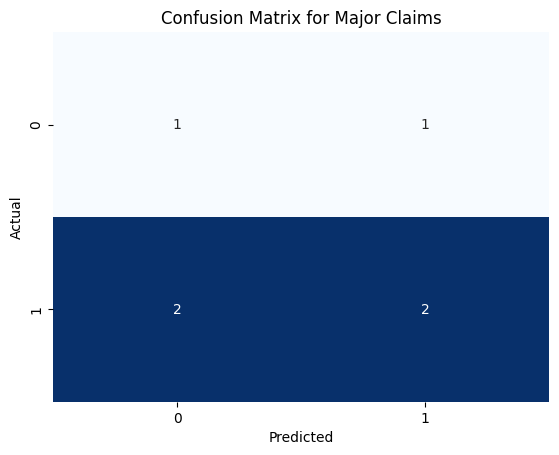

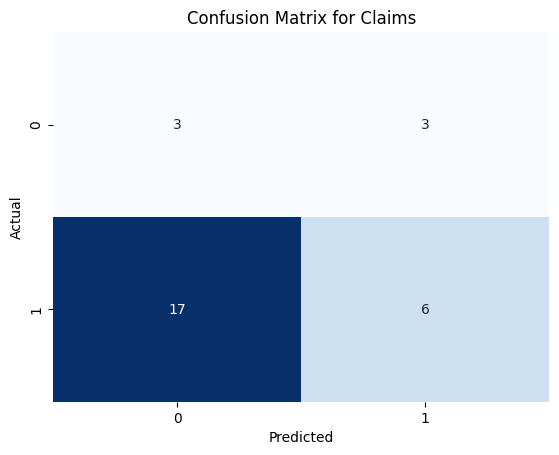

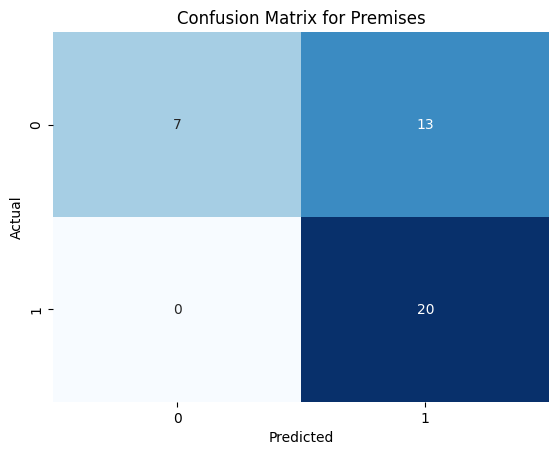

In [59]:
import seaborn as sns

import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(tp, fn, fp, tn, title):
    data = [[tp, fn], [fp, tn]]
    ax = sns.heatmap(data, annot=True, fmt="d", cmap="Blues", cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)
    plt.show()

# Calculate the sum of the columns for overall evaluation
total_tp_mc = merged_df['MajorClaims_TP'].sum()
total_fn_mc = merged_df['MajorClaims_FN'].sum()
total_fp_mc = merged_df['MajorClaims_FP'].sum()
total_tn_mc = merged_df['MajorClaims_TN'].sum()

total_tp_c = merged_df['Claims_TP'].sum()
total_fn_c = merged_df['Claims_FN'].sum()
total_fp_c = merged_df['Claims_FP'].sum()
total_tn_c = merged_df['Claims_TN'].sum()

total_tp_p = merged_df['Premises_TP'].sum()
total_fn_p = merged_df['Premises_FN'].sum()
total_fp_p = merged_df['Premises_FP'].sum()
total_tn_p = merged_df['Premises_TN'].sum()

# Plot confusion matrix for Major Claims
plot_confusion_matrix(
    total_tp_mc,
    total_fn_mc,
    total_fp_mc,
    total_tn_mc,
    'Confusion Matrix for Major Claims'
)

# Plot confusion matrix for Claims
plot_confusion_matrix(
    total_tp_c,
    total_fn_c,
    total_fp_c,
    total_tn_c,
    'Confusion Matrix for Claims'
)

# Plot confusion matrix for Premises
plot_confusion_matrix(
    total_tp_p,
    total_fn_p,
    total_fp_p,
    total_tn_p,
    'Confusion Matrix for Premises'
)

In [48]:
merged_df['claims_eval'].values#[0]
'Only by developing students, can we have a better academic field', 
'the research takes up too much teaching time', 
'professors could teach students through research and projects', 
'professor should concern about preparing class', 
'professors should pay more attention on how to teach students rather than conduct research',
'spending more time to nurture excellent students is more consequential to professors, rather than research'

array([list(['Only by developing students, can we have a better academic field', 'the research takes up too much teaching time', 'professors could teach students through research and projects', 'professor should concern about preparing class', 'professors should pay more attention on how to teach students rather than conduct research', 'spending more time to nurture excellent students is more consequential to professors, rather than research'])],
      dtype=object)

In [49]:
merged_df['claims_os'].values#[0]

'research could bring funding and latest achievements in the field',
'the research takes up too much teaching time',
'professors should assist students to acquire knowledge',
'the professors’ duty is to nurture students, and prepare excellent courses',
'if professors spend a lot of time on research, the time on preparing courses is reduced', 
'this may decrease the quality of classes', 
'students want to learn cutting-edged technologies', 
'professors should provide well-preparation courses to convey the state-of-art knowledge',
'if professors are busy in doing research, it would ruin the reputation of universities', 
'students are unsatisfied with the unprepared course', 
'the enrollment of universities may decline', 
'hardly can professors find assistants to help with projects', 
'spending more time to nurture excellent students is more consequential to professors, rather than research', 
'professors could teach students through research and projects', 
'some students enjoy taking part in some research', 
'they may get more experience in the process of research', 
'only under specific circumstance, when students master all of the systematic knowledge, can they accomplish research',
'this requires professors provide high quality courses', 
'conducting research is helpful for professors and students to some extent',
'professors could combine doing research and preparing good courses in a dynamic way'

array([list(['research could bring funding and latest achievements in the field', 'the research takes up too much teaching time', 'professors should assist students to acquire knowledge', 'the professors’ duty is to nurture students, and prepare excellent courses', 'if professors spend a lot of time on research, the time on preparing courses is reduced', 'this may decrease the quality of classes', 'students want to learn cutting-edged technologies', 'professors should provide well-preparation courses to convey the state-of-art knowledge', 'if professors are busy in doing research, it would ruin the reputation of universities', 'students are unsatisfied with the unprepared course', 'the enrollment of universities may decline', 'hardly can professors find assistants to help with projects', 'spending more time to nurture excellent students is more consequential to professors, rather than research', 'professors could teach students through research and projects', 'some students enjoy takin

In [51]:
merged_df.columns

Index(['json_file', 'json', 'relations_eval', 'major_claims_eval',
       'claims_eval', 'premises_eval', 'os_json', 'relations_os',
       'major_claims_os', 'claims_os', 'premises_os', 'MajorClaims_TP',
       'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN',
       'MajorClaims_Similarity', 'Claims_TP', 'Claims_FN', 'Claims_FP',
       'Claims_TN', 'Claims_Similarity', 'Premises_TP', 'Premises_FN',
       'Premises_FP', 'Premises_TN', 'Premises_Similarity'],
      dtype='object')

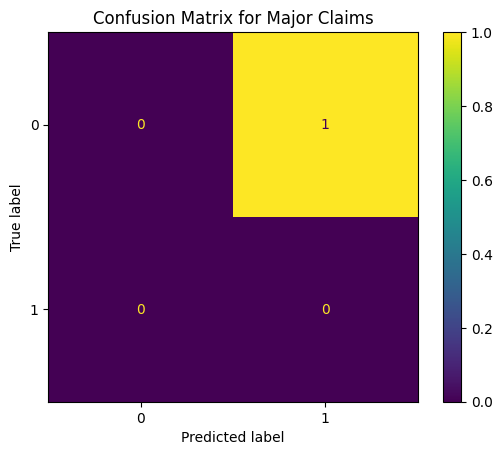

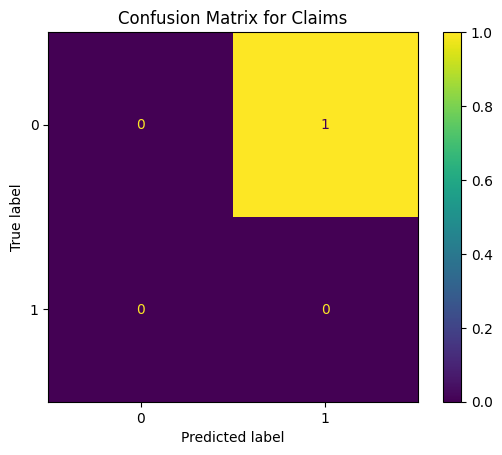

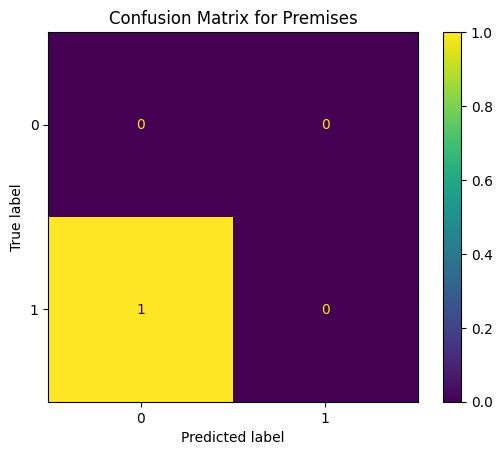

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

# Extract true and predicted labels for major claims, claims, and premises
y_true_mc = merged_df['MajorClaims_TP'] + merged_df['MajorClaims_FN']
y_pred_mc = merged_df['MajorClaims_TP'] + merged_df['MajorClaims_FP']

y_true_c = merged_df['Claims_TP'] + merged_df['Claims_FN']
y_pred_c = merged_df['Claims_TP'] + merged_df['Claims_FP']

y_true_p = merged_df['Premises_TP'] + merged_df['Premises_FN']
y_pred_p = merged_df['Premises_TP'] + merged_df['Premises_FP']

# Plot confusion matrices
plot_confusion_matrix(y_true_mc, y_pred_mc, 'Confusion Matrix for Major Claims')
plot_confusion_matrix(y_true_c, y_pred_c, 'Confusion Matrix for Claims')
plot_confusion_matrix(y_true_p, y_pred_p, 'Confusion Matrix for Premises')

### ground truth for classification metrics

In [82]:
import pandas as pd

def json_to_table(json_obj):
    """
    Transforms a JSON object containing argument components into a table.
    Args:
        json_obj (dict): The JSON object containing 'MajorClaims', 'Claims', and 'Premises'.
    Returns:
        pd.DataFrame: A DataFrame containing 'Type', 'ID', and 'Text' columns.
    """
    # Initialize an empty list to store rows
    table_rows = []

    # Iterate through each type of argument component
    for component_type, components in json_obj.items():
        # Skip 'ArgumentativeRelations' as it's not a text-based component
        if component_type == "ArgumentativeRelations":
            continue
        for component_id, text in components.items():
            # Append a row as (Type, ID, Text)
            table_rows.append({"Type": component_type, "ID": component_id, "Text": text})

    # Convert to a pandas DataFrame
    df = pd.DataFrame(table_rows, columns=["Type", "ID", "Text"])
    return df

# Example JSON object
json_obj = {
    "MajorClaims": {
        "MC1": "Many circumstances that I experienced change the way I think",
        "MC2": "Experiences that shape my thinking teach me to be a better person"
    },
    "Claims": {
        "C1": "These experiences taught me to change my life to be a better person",
        "C2": "There are many experiences that improve my life in many ways",
        "C3": "Studying in university taught me to be more prudent to solve problems",
    },
    "Premises": {
        "P1": "I could find a better way to solve problems",
        "P2": "Experiences could shape me to be more aware of my health",
        "P3": "These experiences could help me plan for my future life",
    },
    "ArgumentativeRelations": [
        {"Origin": "C1", "Relation": "For", "Target": "MC1"},
        {"Origin": "P1", "Relation": "supports", "Target": "C1"},
    ]
}

# Transform the JSON object into a table
table = json_to_table(json_obj)

# Display the table
table

,Type,ID,Text
0,MajorClaims,MC1,Many circumstances that I experienced change t...
1,MajorClaims,MC2,Experiences that shape my thinking teach me to...
2,Claims,C1,These experiences taught me to change my life ...
3,Claims,C2,There are many experiences that improve my lif...
4,Claims,C3,Studying in university taught me to be more pr...
5,Premises,P1,I could find a better way to solve problems
6,Premises,P2,Experiences could shape me to be more aware of...
7,Premises,P3,These experiences could help me plan for my fu...


In [84]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def jaccard_similarity(text1, text2):
    """Calculate Jaccard similarity between two texts."""
    set1, set2 = set(text1.split()), set(text2.split())
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

def match_components(predicted, references, threshold=0.5):
    """
    Matches predicted components to reference components using Jaccard similarity.
    Args:
        predicted (list): List of predicted texts.
        references (list): List of reference texts.
        threshold (float): Similarity threshold for matching.
    Returns:
        matches (list): List of (predicted_index, reference_index) matches.
    """
    similarity_matrix = np.zeros((len(predicted), len(references)))

    # Compute similarity matrix
    for i, pred in enumerate(predicted):
        for j, ref in enumerate(references):
            similarity_matrix[i, j] = jaccard_similarity(pred, ref)

    # Match predictions to references
    matches = []
    for i, row in enumerate(similarity_matrix):
        best_match_idx = np.argmax(row)
        if row[best_match_idx] >= threshold:
            matches.append((i, best_match_idx))

    return matches

def confusion_matrix_for_components(predicted_json, reference_json, threshold=0.5):
    """
    Calculates a confusion matrix for argumentative components.
    Args:
        predicted_json (dict): Predicted JSON object with 'MajorClaims', 'Claims', 'Premises'.
        reference_json (dict): Reference JSON object with the same structure.
        threshold (float): Similarity threshold for matching.
    Returns:
        dict: Confusion matrix counts for each component type.
    """
    confusion_counts = {component: {"TP": 0, "FP": 0, "FN": 0} 
                        for component in ["MajorClaims", "Claims", "Premises"]}
    
    for component_type in confusion_counts.keys():
        predicted = list(predicted_json.get(component_type, {}).values())
        references = list(reference_json.get(component_type, {}).values())

        # Match predictions to references
        matches = match_components(predicted, references, threshold)
        matched_preds = {m[0] for m in matches}
        matched_refs = {m[1] for m in matches}

        # Calculate TP, FP, FN
        confusion_counts[component_type]["TP"] = len(matches)
        confusion_counts[component_type]["FP"] = len(predicted) - len(matched_preds)
        confusion_counts[component_type]["FN"] = len(references) - len(matched_refs)

    return confusion_counts

# Example usage
predicted_json = {
    "MajorClaims": {"MC1": "Circumstances change my way of thinking"},
    "Claims": {"C1": "Experiences taught me to improve my life"},
    "Premises": {"P1": "I could find a way to solve problems"}
}

reference_json = {
    "MajorClaims": {"MC1": "Many circumstances that I experienced change the way I think"},
    "Claims": {
        "C1": "These experiences taught me to change my life",
        "C2": "There are many experiences that improve my life"
    },
    "Premises": {"P1": "I could find a better way to solve problems"}
}

confusion_counts = confusion_matrix_for_components(predicted_json, reference_json)
print(confusion_counts)


{'MajorClaims': {'TP': 0, 'FP': 1, 'FN': 1}, 'Claims': {'TP': 1, 'FP': 0, 'FN': 1}, 'Premises': {'TP': 1, 'FP': 0, 'FN': 0}}


## Evaluation metrics

### Jaccard Score

c:\Users\ben-s\anaconda3\envs\llm\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['spending more time to nurture excellent students is more consequential to professors, rather than research', 'the precondition of doing research is growing students’ solid theory fundamental'] will be ignored
  warnings.warn(


0.6666666666666666
0.5


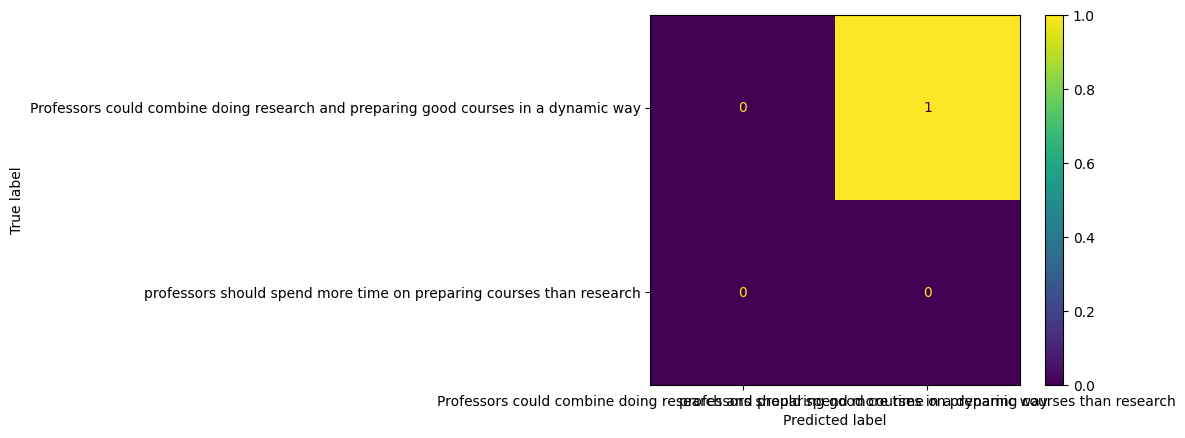

In [52]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, jaccard_score

#TODO: MultiLabelBinarizer verstehen 

# Binarize the true and predicted labels
mlb = MultiLabelBinarizer()
y_true_mc_bin = mlb.fit_transform(y_true_mc)
y_pred_mc_os_bin = mlb.transform(y_pred_mc_os)


# calculate the F1 score for the major claims
f1_mc = f1_score(y_true_mc_bin, y_pred_mc_os_bin, average='micro')
print(f1_mc)


# calculate the Jaccard score for the major claims
jaccard_mc = jaccard_score(y_true_mc_bin, y_pred_mc_os_bin, average='micro')
print(jaccard_mc)

# Quelle Jaccard Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html#sklearn.metrics.jaccard_score
# Wuelle f1_Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

# plot a confusion matrix for the major claims
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_mc_bin.argmax(axis=1), y_pred_mc_os_bin.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlb.classes_)
disp.plot()
#plt.show()

# Quelle Confusion Matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

In [71]:

import numpy as np

def jaccard_similarity(list1, list2):
    """Calculate the Jaccard similarity between two lists of sentences"""
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Calculate Jaccard similarity for major claims, claims, and premises
for idx, row in merged_df.iterrows():
    merged_df.at[idx, 'major_claims_similarity'] = round(jaccard_similarity(row['major_claims_eval'], row['major_claims_os']),2)
    merged_df.at[idx, 'claims_similarity'] = round(jaccard_similarity(row['claims_eval'], row['claims_os']),2)
    merged_df.at[idx, 'premises_similarity'] = round(jaccard_similarity(row['premises_eval'], row['premises_os']), 2)

    #major_claims_similarity = jaccard_similarity(row['major_claims_eval'], row['major_claims_os'])
    #claims_similarity = jaccard_similarity(row['claims_eval'], row['claims_os'])
    #premises_similarity = jaccard_similarity(row['premises_eval'], row['premises_os'])
    
    #print(f"Major Claims Jaccard Similarity: {major_claims_similarity}")
    #print(f"Claims Jaccard Similarity: {claims_similarity}")
    #print(f"Premises Jaccard Similarity: {premises_similarity}")

merged_df

,json_file,json,relations_eval,major_claims_eval,claims_eval,premises_eval,os_json,relations_os,major_claims_os,claims_os,premises_os,major_claims_similarity,claims_similarity,premises_similarity,major_claims_bleu,claims_bleu,premises_bleu
0,essay169.json,{'MajorClaims': {'MC1': 'Professors could comb...,"[(Only by developing students, can we have a b...",[Professors could combine doing research and p...,"[Only by developing students, can we have a be...",[conducting research is helpful for professors...,{'MajorClaims': {'MC1': 'professors should spe...,[(research could bring funding and latest achi...,[professors should spend more time on preparin...,[research could bring funding and latest achie...,[the reason why people enter a university is t...,0.25,0.13,0.04,0.262574,0.155252,0.092586


### BLEU Score

In [30]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# compare llm answer with the original text
def bleu_score(reference, candidate):
    """Calculate the BLEU score between the reference and candidate texts"""
    reference = reference.split()
    candidate = candidate.split()
    return sentence_bleu([reference], candidate)


for idx, row in merged_df.iterrows():
    major_claims_bleu = bleu_score(' '.join(row['major_claims_eval']), ' '.join(row['major_claims_os']))
    claims_bleu = bleu_score(' '.join(row['claims_eval']), ' '.join(row['claims_os']))
    premises_bleu = bleu_score(' '.join(row['premises_eval']), ' '.join(row['premises_os']))
    
    merged_df.at[idx, 'major_claims_bleu'] = major_claims_bleu
    merged_df.at[idx, 'claims_bleu'] = claims_bleu
    merged_df.at[idx, 'premises_bleu'] = premises_bleu


merged_df

,json_file,json,relations_eval,major_claims_eval,claims_eval,premises_eval,os_json,relations_os,major_claims_os,claims_os,premises_os,major_claims_similarity,claims_similarity,premises_similarity,major_claims_bleu,claims_bleu,premises_bleu
0,essay169.json,{'MajorClaims': {'MC1': 'Professors could comb...,"[(Only by developing students, can we have a b...",[Professors could combine doing research and p...,"[Only by developing students, can we have a be...",[conducting research is helpful for professors...,{'MajorClaims': {'MC1': 'professors should spe...,[(research could bring funding and latest achi...,[professors should spend more time on preparin...,[research could bring funding and latest achie...,[the reason why people enter a university is t...,0.25,0.130435,0.04,0.262574,0.155252,0.092586


### BERTScore

In [60]:
from evaluate import load

In [66]:
merged_df['major_claims_os'].values[0]

['professors should spend more time on preparing courses than research',
 'spending more time to nurture excellent students is more consequential to professors, rather than research',
 'the precondition of doing research is growing students’ solid theory fundamental']

In [70]:
bertscore = load('bertscore')
predictions = merged_df['major_claims_os'].values[0][:2]  # Adjust predictions to match the length of references
references = merged_df['major_claims_eval'].values[0]
results = bertscore.compute(predictions=predictions, references=references, lang='en')
results

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\ben-s\anaconda3\envs\llm\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ben-s\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

c:\Users\ben-s\anaconda3\envs\llm\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.8966709971427917, 0.8940051794052124],
 'recall': [0.8847197890281677, 0.9011836647987366],
 'f1': [0.8906553387641907, 0.8975800275802612],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.45.1)'}

### Sonstiges / Alles

In [80]:
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
from difflib import SequenceMatcher

def token_level_metrics(predicted, ground_truth):
    pred_tokens = set(predicted.split())
    gt_tokens = set(ground_truth.split())

    intersection = pred_tokens & gt_tokens
    union = pred_tokens | gt_tokens

    precision = len(intersection) / len(pred_tokens) if pred_tokens else 0
    recall = len(intersection) / len(gt_tokens) if gt_tokens else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    jaccard = len(intersection) / len(union) if union else 0

    return precision, recall, f1, jaccard

def bleu_score(predicted, ground_truth):
    return sentence_bleu([ground_truth.split()], predicted.split(), weights=(0.25, 0.25, 0.25, 0.25))



# Example usage
predicted = "Studying at university taught me"
ground_truth = "Studying in university taught me to solve problems prudently"

# Token-level metrics
token_precision, token_recall, token_f1, jaccard = token_level_metrics(predicted, ground_truth)
print(f"Token-Level Metrics: Precision={token_precision:.2f}, Recall={token_recall:.2f}, F1={token_f1:.2f}, Jaccard={jaccard:.2f}")

# BLEU score
bleu = bleu_score(predicted, ground_truth)
print(f"BLEU Score: {bleu:.2f}")

Token-Level Metrics: Precision=0.80, Recall=0.44, F1=0.57, Jaccard=0.40
BLEU Score: 0.00
